In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, ydata_profiling, shap

In [2]:
warnings.filterwarnings('ignore')

In [3]:
df= pd.read_csv('./data/cardata.csv', index_col=0)

EDA

In [4]:
summary = df.describe()

In [5]:
summary.drop(['nrOfPictures','postalCode'],axis=1,inplace=True)

In [6]:
summary

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration
count,3.715280e+05,371528.000000,371528.000000,371528.000000,371528.000000
mean,1.729514e+04,2004.577997,115.549477,125618.688228,5.734445
std,3.587954e+06,92.866598,192.139578,40112.337051,3.712412
min,0.000000e+00,1000.000000,0.000000,5000.000000,0.000000
25%,1.150000e+03,1999.000000,70.000000,125000.000000,3.000000
50%,2.950000e+03,2003.000000,105.000000,150000.000000,6.000000
75%,7.200000e+03,2008.000000,150.000000,150000.000000,9.000000
max,2.147484e+09,9999.000000,20000.000000,150000.000000,12.000000


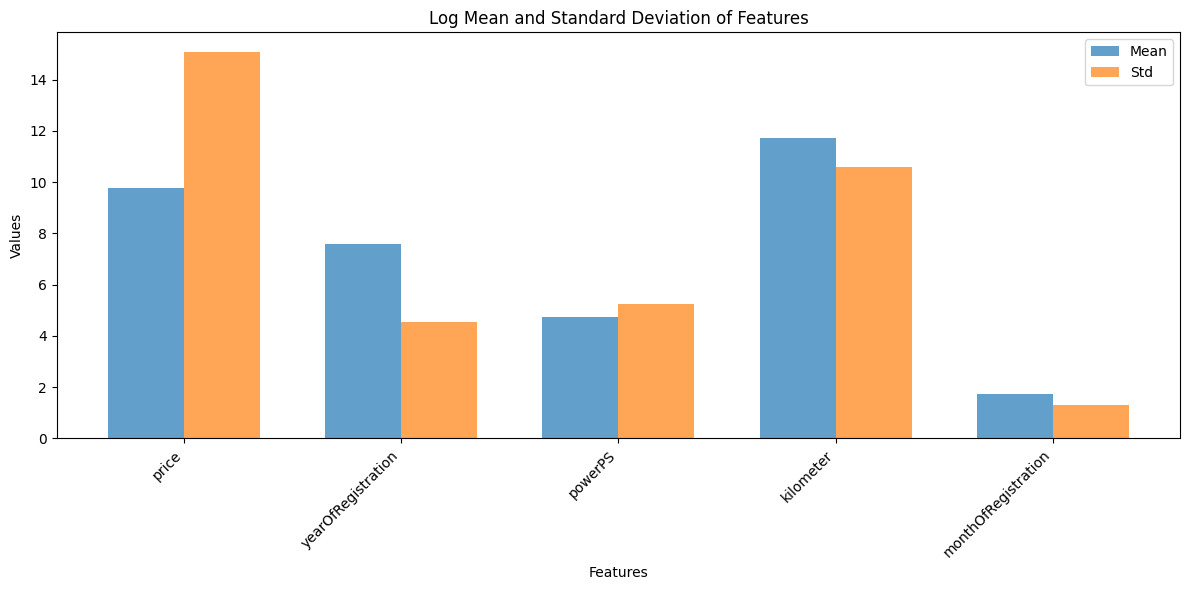

In [7]:
x_labels = list(summary.columns)
y1 = np.log(list(summary.loc['mean']))
y2 = np.log(list(list(summary.loc['std'])))

width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))

plt.bar(x - width/2, y1, width=width, label='Mean', alpha=0.7)
plt.bar(x + width/2, y2, width=width, label='Std', alpha=0.7)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Log Mean and Standard Deviation of Features')
plt.legend()

plt.tight_layout()
plt.show()

**Note:**  
- `powerPS`, `yearOfRegistration`, and `monthOfRegistration` exhibit very little variation (low standard deviation). Further investigation will be conducted.


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          371528 non-null  object
 1   name                 371528 non-null  object
 2   seller               371528 non-null  object
 3   offerType            371528 non-null  object
 4   price                371528 non-null  int64 
 5   abtest               371528 non-null  object
 6   vehicleType          333659 non-null  object
 7   yearOfRegistration   371528 non-null  int64 
 8   gearbox              351319 non-null  object
 9   powerPS              371528 non-null  int64 
 10  model                351044 non-null  object
 11  kilometer            371528 non-null  int64 
 12  monthOfRegistration  371528 non-null  int64 
 13  fuelType             338142 non-null  object
 14  brand                371528 non-null  object
 15  notRepairedDamage    299468 non-null  o

In [9]:
# Missing Values
dataInfo =[]
for col in df.columns:
  num_nam = df[col].isna().sum()
  dataInfo.append([col,num_nam,num_nam/len(df)*100,df[col].nunique()])

In [10]:
mising_value_df = pd.DataFrame(dataInfo,columns=['Feature','NumNan','PercentNan','NumUnique'])

In [11]:
mising_value_df

,Feature,NumNan,PercentNan,NumUnique
0,dateCrawled,0,0.000000,280500
1,name,0,0.000000,233531
2,seller,0,0.000000,2
3,offerType,0,0.000000,2
4,price,0,0.000000,5597
5,abtest,0,0.000000,2
6,vehicleType,37869,10.192771,8
7,yearOfRegistration,0,0.000000,155
8,gearbox,20209,5.439429,2
9,powerPS,0,0.000000,794


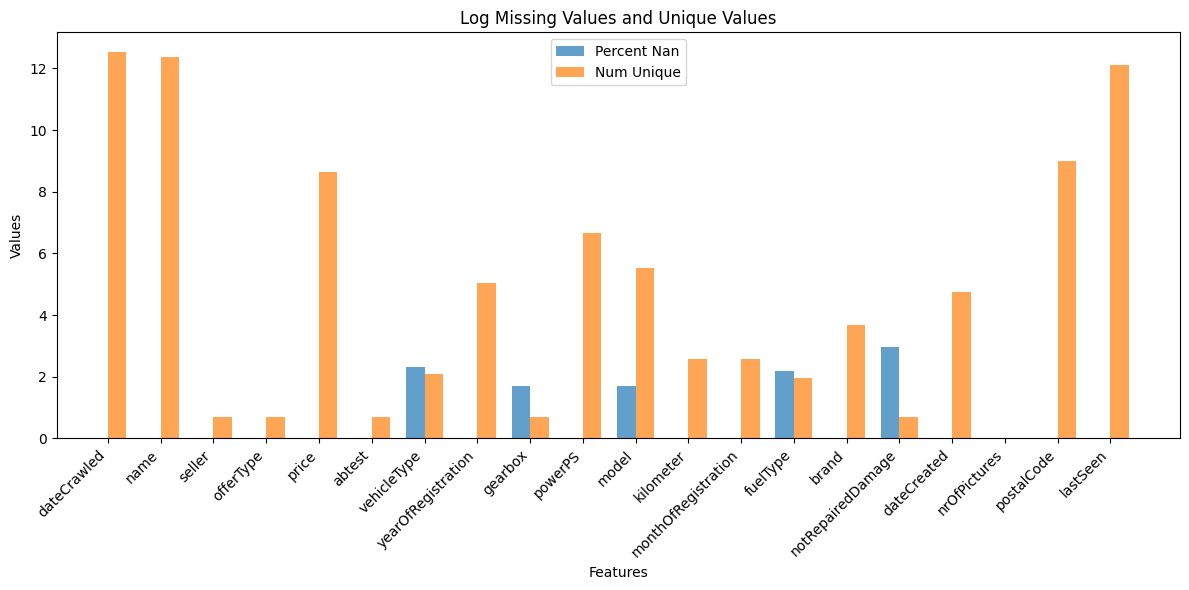

In [12]:
x_labels = list(mising_value_df['Feature'])
y1 = np.log(list(mising_value_df['PercentNan']))
y2 = np.log(list(mising_value_df['NumUnique']))

width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(12,6))

plt.bar(x - width/2, y1, width=width, label='Percent Nan', alpha=0.7)
plt.bar(x + width/2, y2, width=width, label='Num Unique', alpha=0.7)

plt.xticks(x, x_labels, rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Log Missing Values and Unique Values')
plt.legend()

plt.tight_layout()
plt.show()

**Note:**

- `nrOfPictures` has only one unique value and will be removed.
- `vehicleType` and `notRepairedDamage` have the highest number of missing values; these will require further investigation.


In [13]:
df.drop('nrOfPictures', axis=1, inplace=True)

In [14]:
# 4. German to English, as best as I can
df['gearbox'] = df['gearbox'].apply(lambda g: 'Manual' if g == 'manuell' else 'Automatic')
df['notRepairedDamage'] = df['notRepairedDamage'].apply(lambda g: 'Yes' if g == 'ja' else 'No' if g =='nein' else 'NaN')
df.loc[df['fuelType'] == 'benzin', 'fuelType'] = 'Petrol'
df.loc[df['fuelType'] == 'andere', 'fuelType'] = 'Other'

In [15]:
categorical_cols = ['seller','abtest','vehicleType','gearbox','fuelType','notRepairedDamage','offerType']
data = []
for col in categorical_cols:
  data.append(df[col].value_counts())

**Note:**

- `brand`, `model`, and `powerPS` have a large number of unique values; therefore, representing them with pie charts is not meaningful.


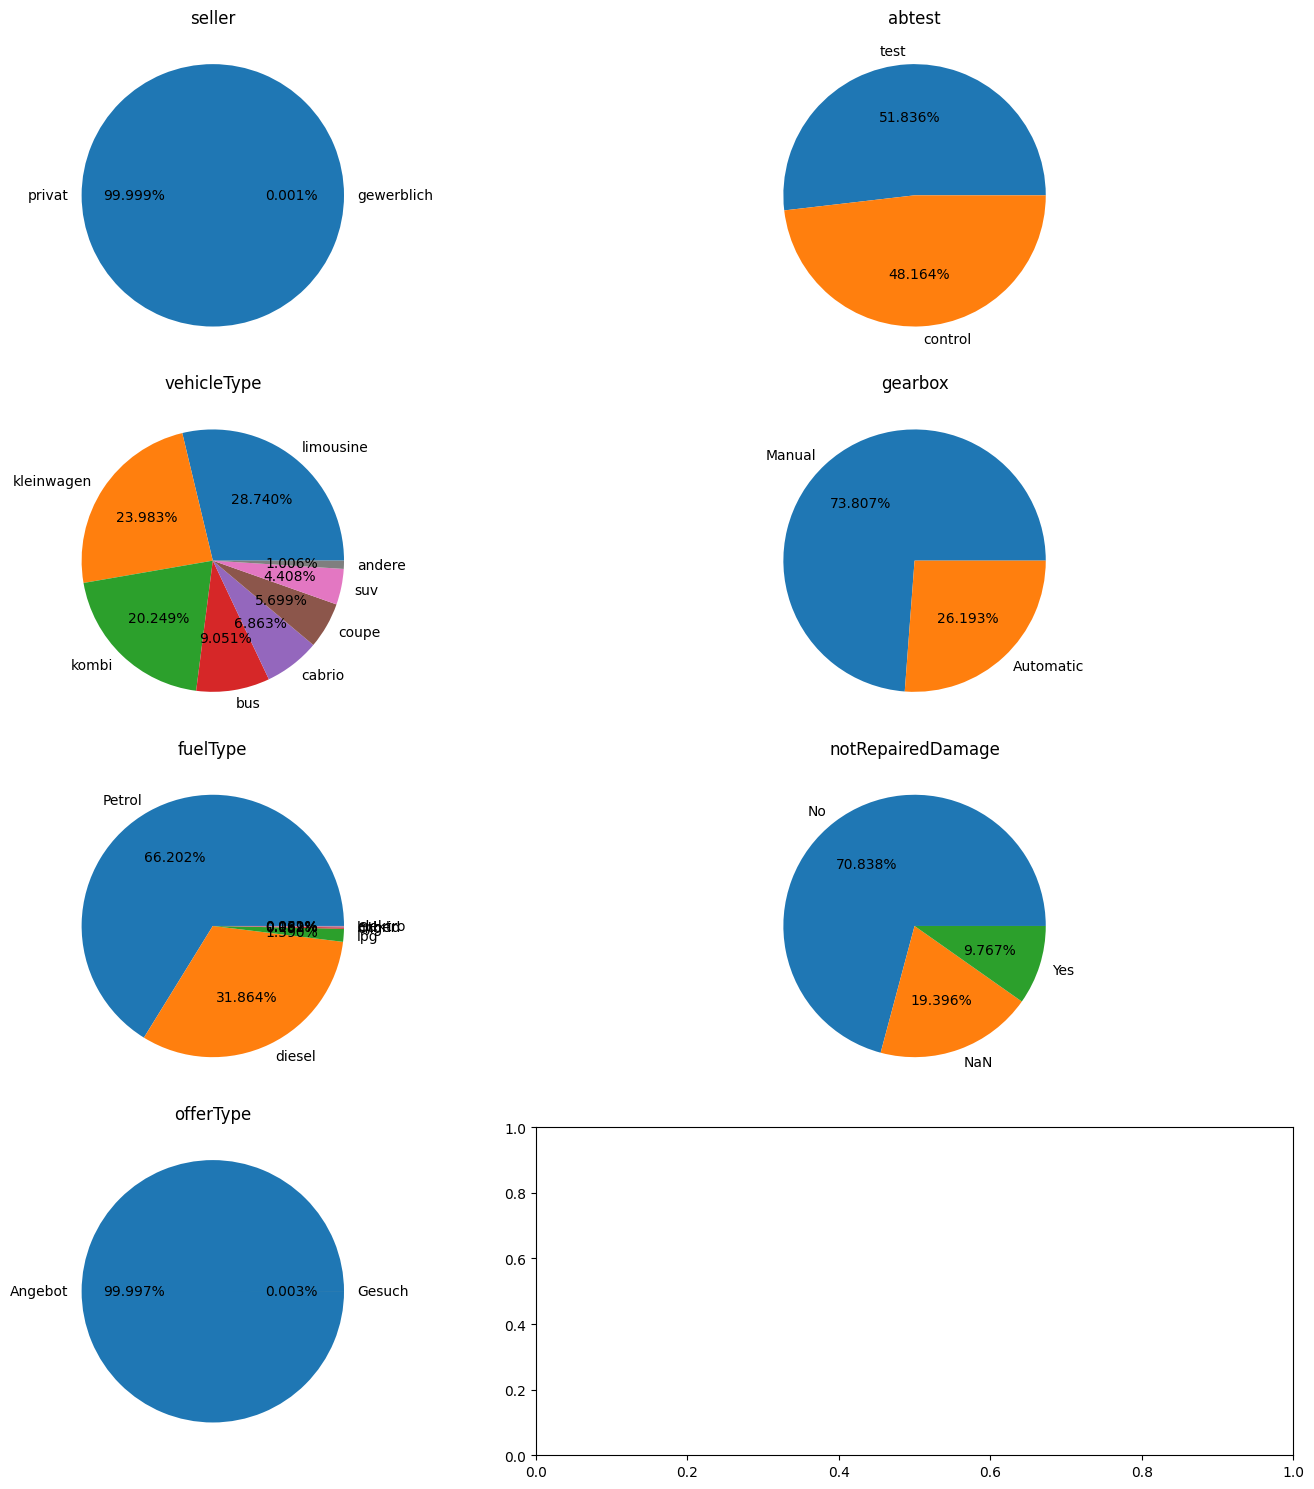

In [16]:
fig,ax = plt.subplots(4,2,figsize=(15,15))
axes = ax.flatten()
for i,col_data in enumerate(data):
  axes[i].pie(col_data,labels=col_data.index,autopct='%1.3f%%')
  axes[i].set_title(categorical_cols[i])
plt.tight_layout()
plt.show()

**Note:**

- `seller` and `offerType` each have only 2 unique values, with one value appearing in less than 0.003% of rows. These columns will be removed.
- Rows with rare `fuelType` values (`lpg`, `cng`, `hybrid`, `other`, and `elektro`) contribute very little to the dataset and will be dropped.
- `notRepairedDamage` contains 19.3% missing values; rows with missing entries in this column will be removed.


In [17]:
# Drop the 'seller', 'offerType' columns
df.drop('seller', axis=1, inplace=True)
df.drop('offerType', axis=1, inplace=True)


# Drop rows with feul type lpg, cng etc
df = df[(df['fuelType'] == 'Petrol') | (df['fuelType'] == 'Diesel')]

df.head()

,dateCrawled,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode,lastSeen
index,,,,,,,,,,,,,,,,,
0,2016-03-24 11:52:17,Golf_3_1.6,480,test,NaN,1993,Manual,0,golf,150000,0,Petrol,volkswagen,NaN,2016-03-24 00:00:00,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17 00:00:00,91074,2016-03-17 17:40:17
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04 00:00:00,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01 00:00:00,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,VW_Derby_Bj_80__Scheunenfund,0,test,limousine,1980,Manual,50,andere,40000,7,Petrol,volkswagen,No,2016-03-21 00:00:00,19348,2016-03-25 16:47:58


**Note:**

- `lastSeen` and `dateCrawled` will be removed as they have no impact on the target variable (`price`).
- Rows with `yearOfRegistration` below 1980 or above 2025 will be dropped, as values outside this range are likely erroneous.


In [18]:
#  DateTime Conversion --> Drop 'dateCrawled' and 'lastSeen'
df.drop(['lastSeen', 'dateCrawled'], axis=1, inplace=True)
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
#  Define a range for the 'yearOfRegistration'
df = df[df['yearOfRegistration'].between(1980, 2025)]

In [19]:
df.head()

,name,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,postalCode
index,,,,,,,,,,,,,,,
0,Golf_3_1.6,480,test,NaN,1993,Manual,0,golf,150000,0,Petrol,volkswagen,NaN,2016-03-24,70435
3,GOLF_4_1_4__3TÜRER,1500,test,kleinwagen,2001,Manual,75,golf,150000,6,Petrol,volkswagen,No,2016-03-17,91074
5,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,650,test,limousine,1995,Manual,102,3er,150000,10,Petrol,bmw,Yes,2016-04-04,33775
6,Peugeot_206_CC_110_Platinum,2200,test,cabrio,2004,Manual,109,2_reihe,150000,8,Petrol,peugeot,No,2016-04-01,67112
7,VW_Derby_Bj_80__Scheunenfund,0,test,limousine,1980,Manual,50,andere,40000,7,Petrol,volkswagen,No,2016-03-21,19348


### Count Analysis of `brand`

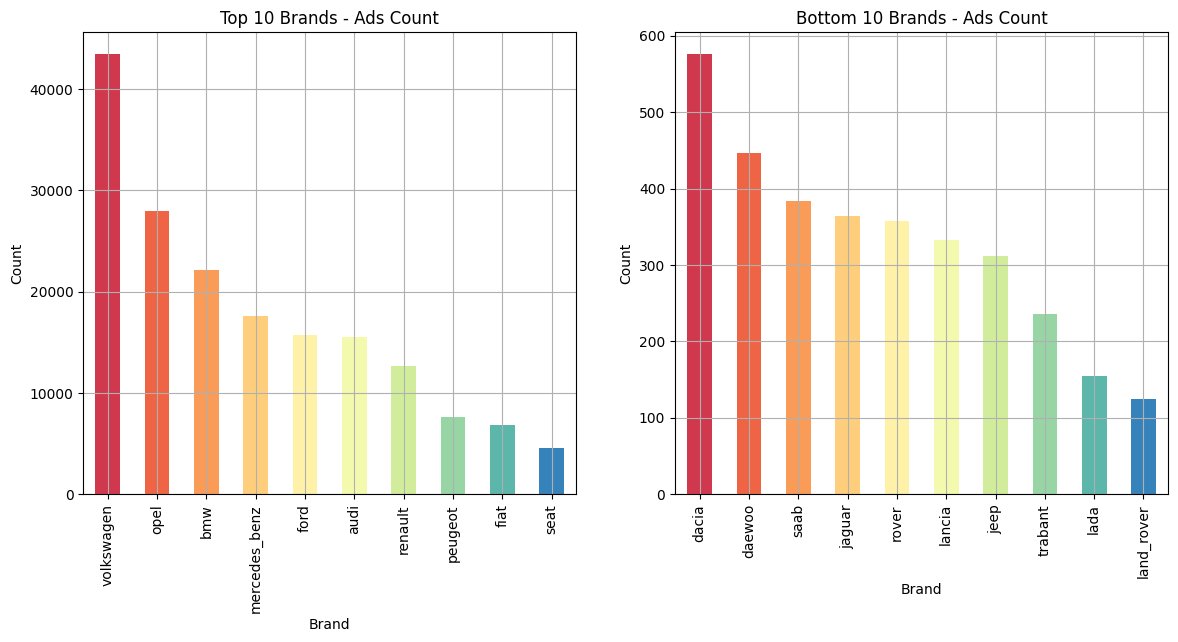

In [20]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['brand'].value_counts().head(10).plot(kind='bar', title='Top 10 Brands - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['brand'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Brands - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note:**

- There is a high degree of variance in the `brand` feature, indicating that the data is diverse and potentially valuable for analysis.


### Count analysis of models

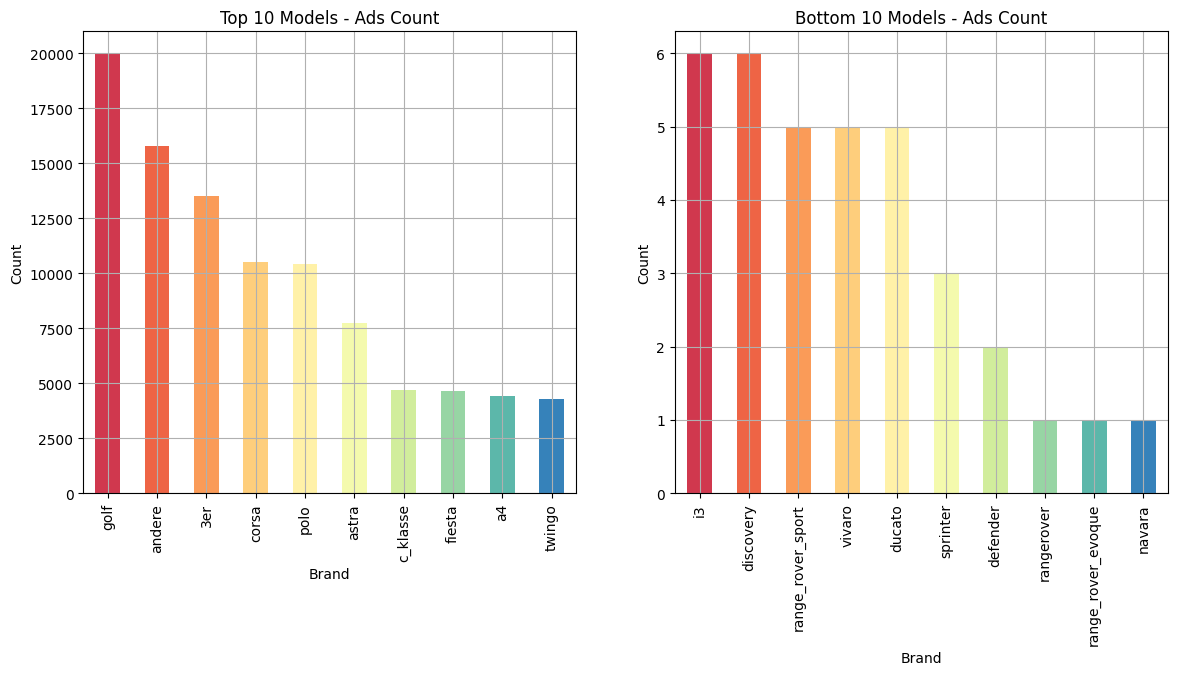

In [21]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['model'].value_counts().head(10).plot(kind='bar', title='Top 10 Models - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['model'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 Models - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note** 
- Clearly lots of varaince. so data is useful

### Count analysis of Vechile type

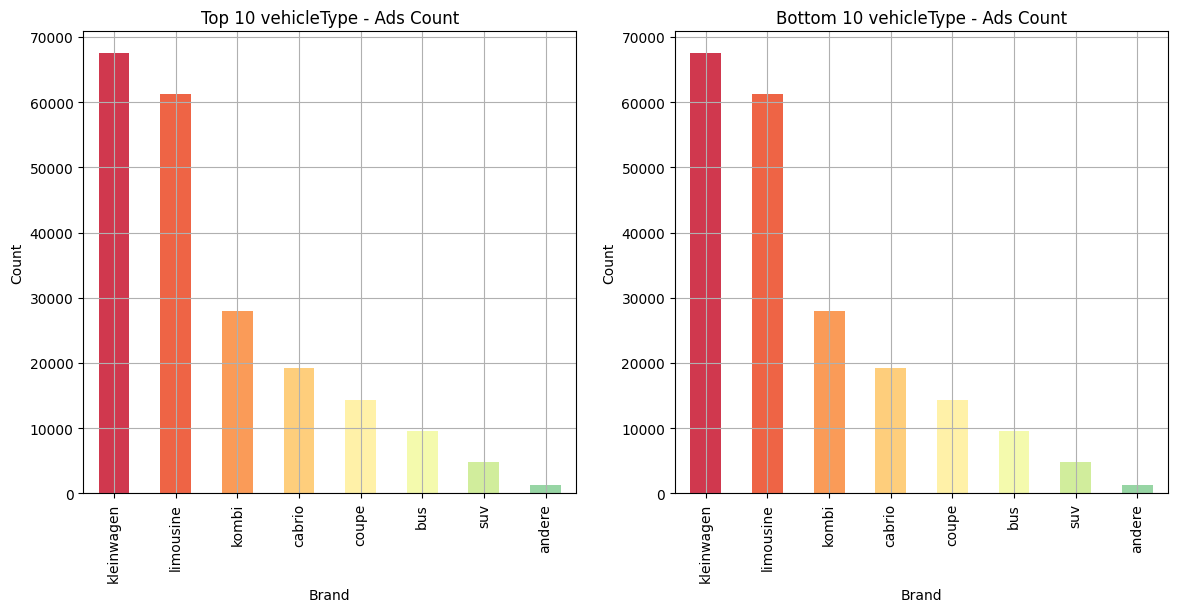

In [22]:
colors_10_1 = sns.color_palette("Spectral", 10)
colors_10_2 = sns.color_palette("Set3", 10)
colors_5 = sns.color_palette('Accent', 5)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

df['vehicleType'].value_counts().head(10).plot(kind='bar', title='Top 10 vehicleType - Ads Count', color=colors_10_1, ax=axes[0], xlabel='Brand', ylabel='Count', grid=True)
df['vehicleType'].value_counts().tail(10).plot(kind='bar', title='Bottom 10 vehicleType - Ads Count', color=colors_10_1, ax=axes[1], xlabel='Brand', ylabel='Count', grid=True)
plt.show()

**Note** 
- Clearly lots of varaince. so data is useful

### Comparative Analysis of `model` and `brand`

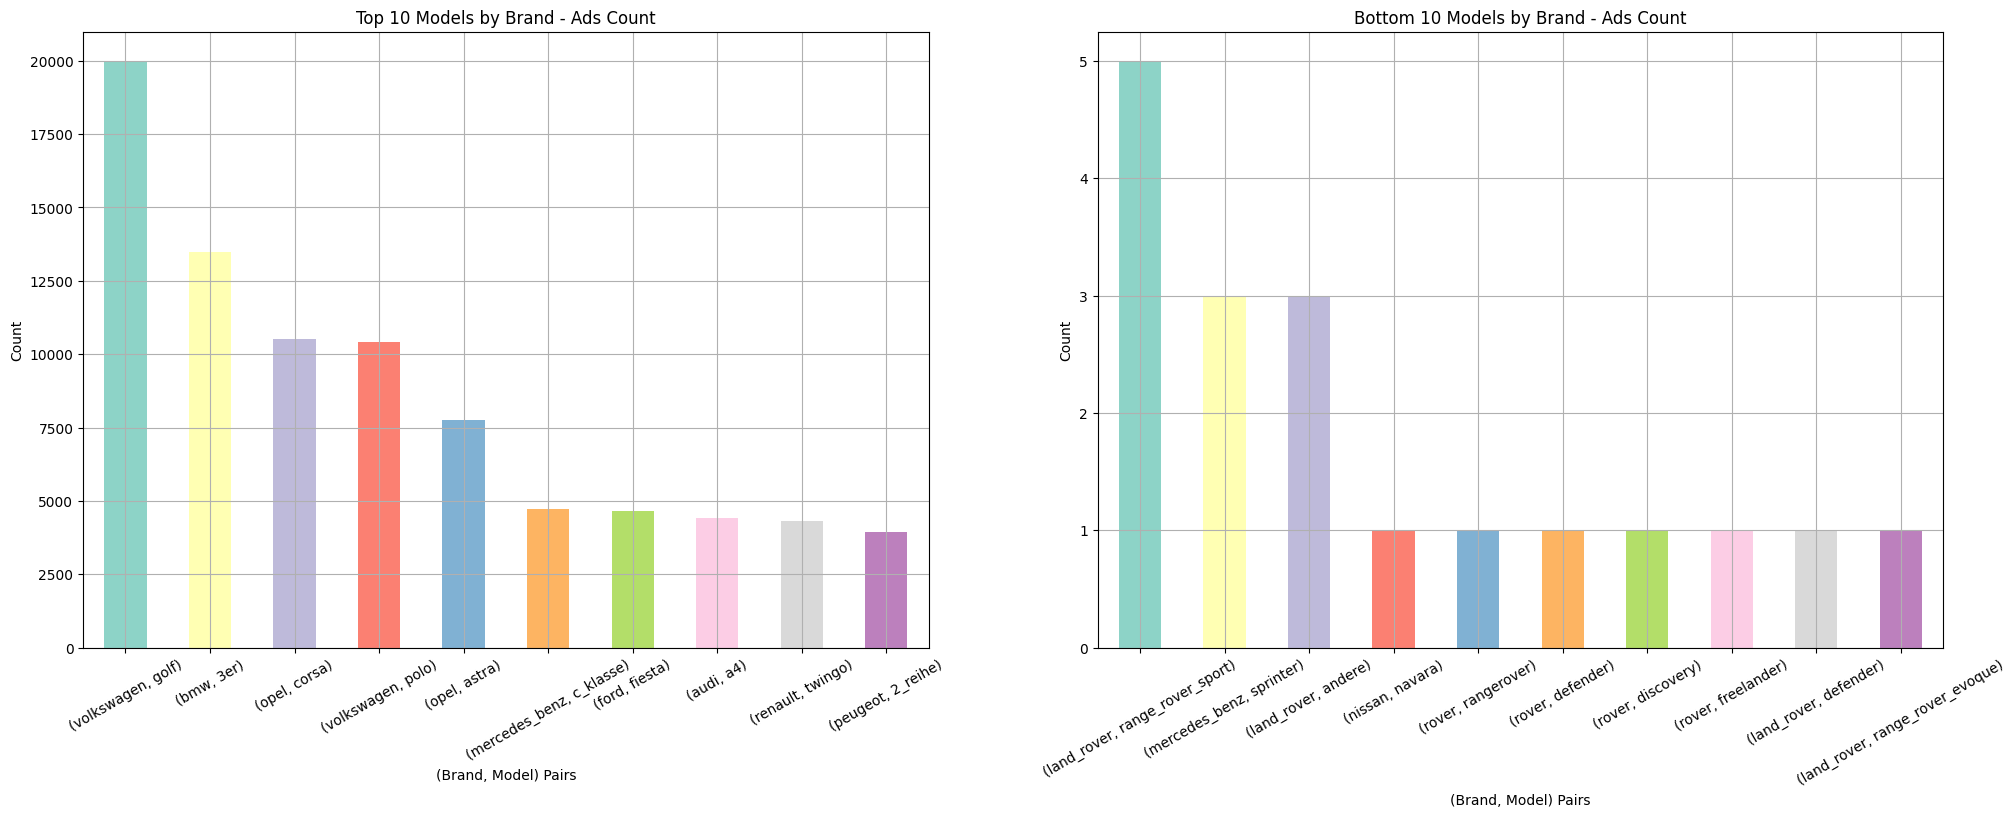

In [23]:
group_by_brand = df.groupby('brand')['model'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

group_by_brand.head(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Top 10 Models by Brand - Ads Count', ax=axes[0], color=colors_10_2)
group_by_brand.tail(10).plot(kind='bar', grid=True, rot=30, xlabel="(Brand, Model) Pairs", ylabel='Count', title='Bottom 10 Models by Brand - Ads Count', ax=axes[1], color=colors_10_2)
plt.show()

### Comparative Analysis of `vehicleType`, `brand`, and `model`

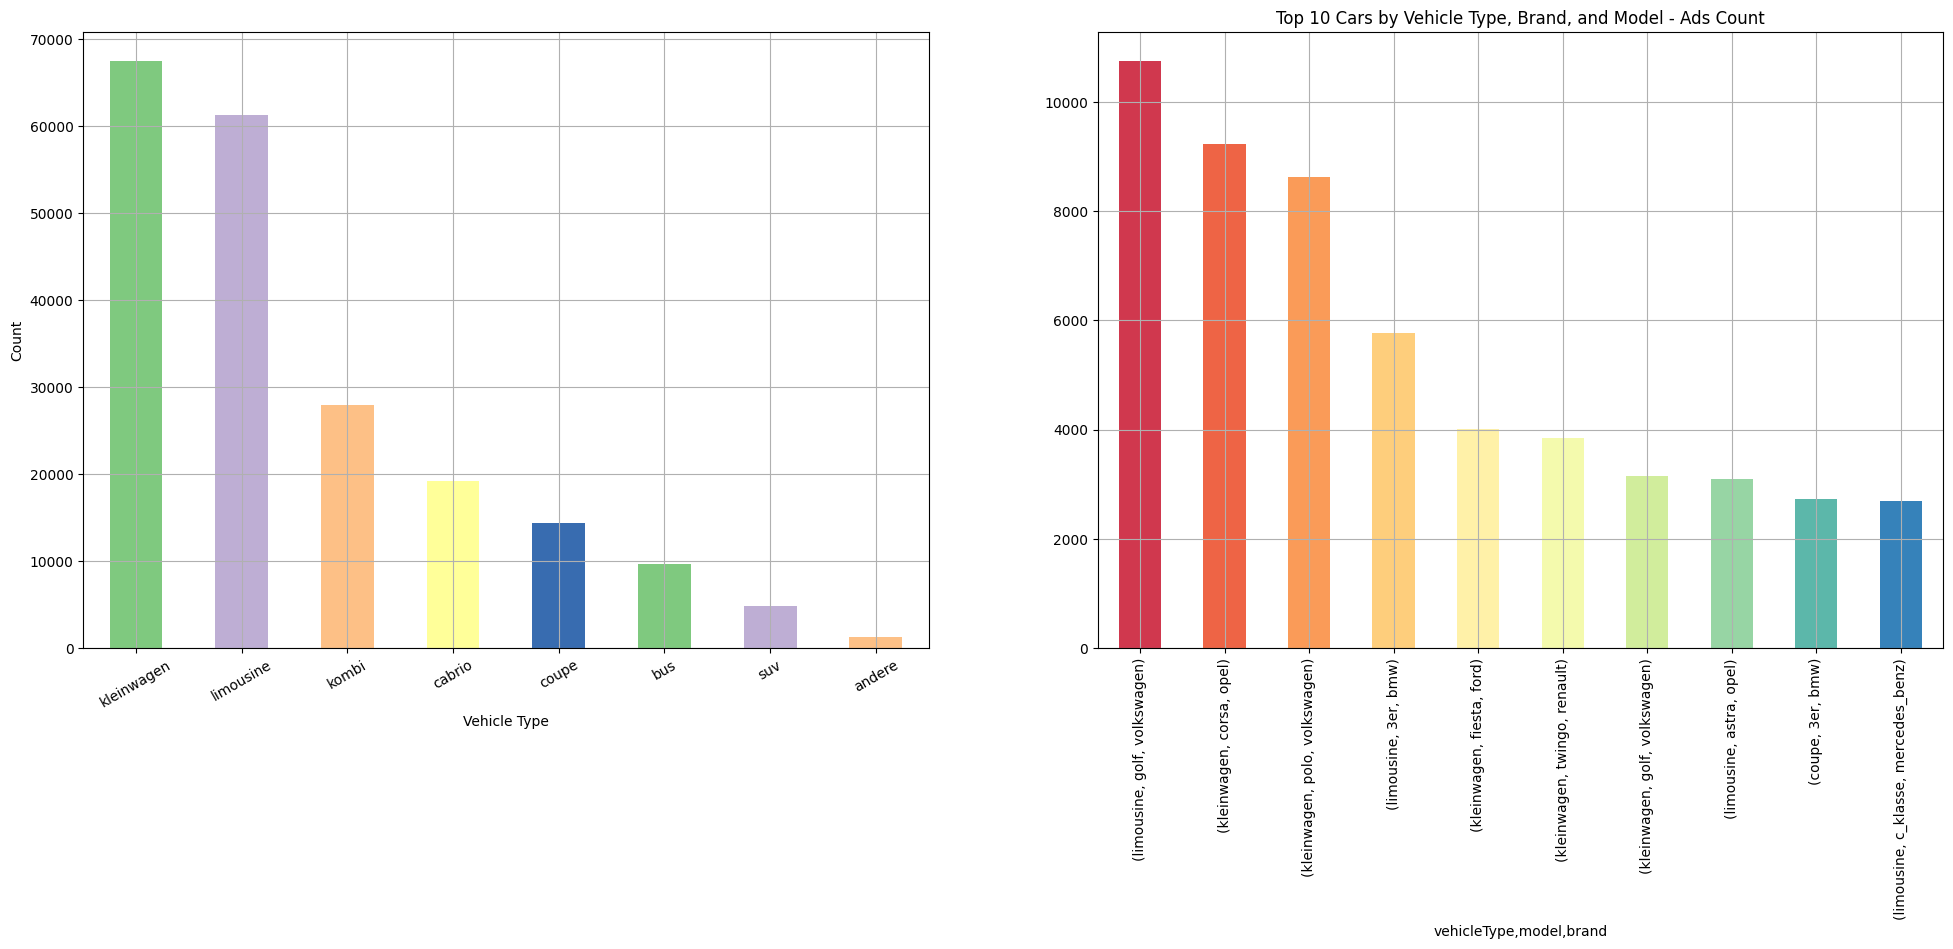

In [24]:
group_by_vehicle_type = df.groupby('vehicleType')[['model', 'brand']].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 8))

df['vehicleType'].value_counts().plot(kind='bar', color=colors_5, ax=axes[0], grid=True, rot=30, xlabel='Vehicle Type', ylabel='Count', title='')
group_by_vehicle_type.head(10).plot(kind='bar', grid=True, color=colors_10_1, ax=axes[1], title='Top 10 Cars by Vehicle Type, Brand, and Model - Ads Count')
plt.show()

In [25]:
numerical_cols = ['powerPS','kilometer','monthOfRegistration','yearOfRegistration']

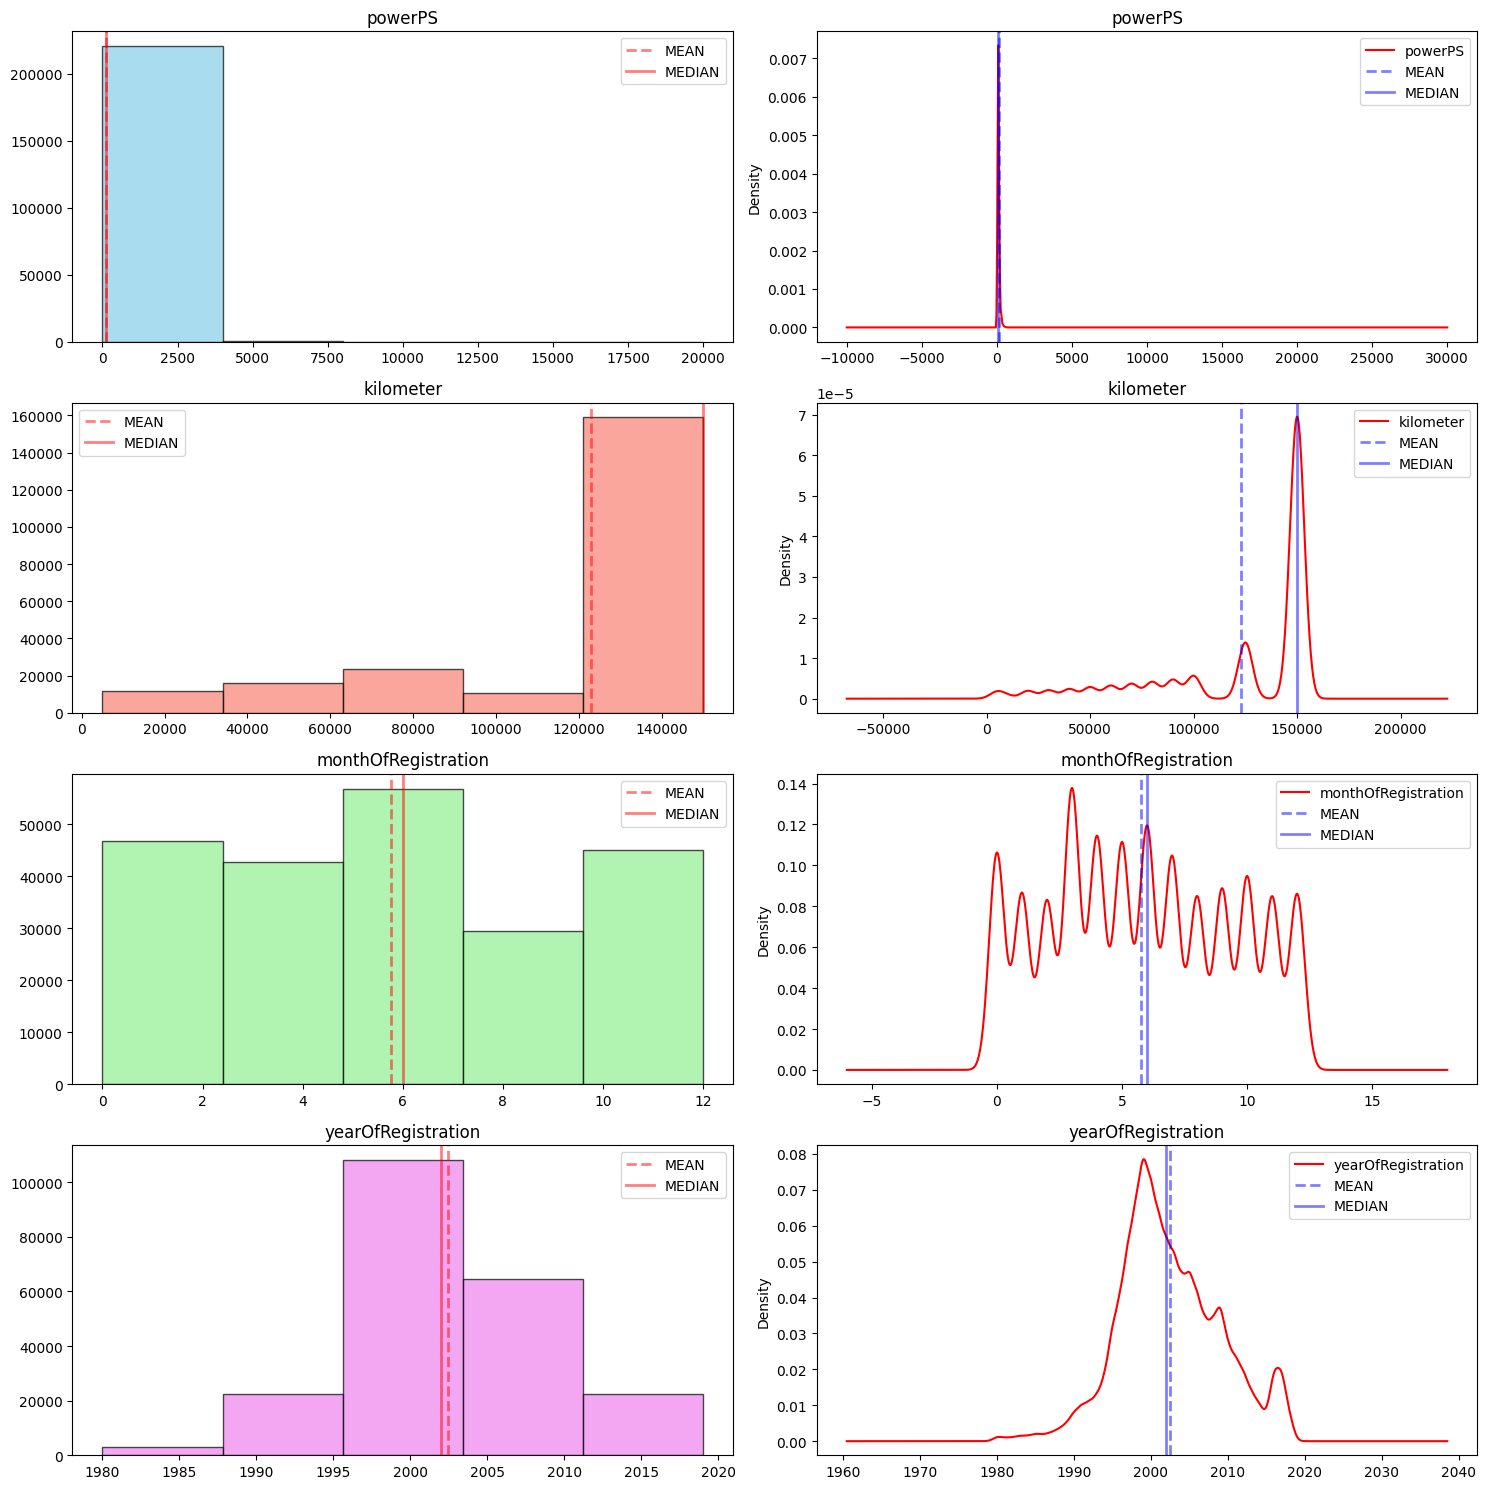

In [26]:
fig, axes= plt.subplots(4, 2, figsize=(15, 15))

# Define distinct colors for each plot
colors = ['skyblue', 'salmon', 'lightgreen', 'violet', 'gold', 'lightcoral']

for i, col in enumerate(numerical_cols):
    km_mean = df[col].mean()
    km_median = df[col].median()
    axes[i][0].hist(df[col].dropna(), bins=5, color=colors[i], edgecolor='black', alpha=0.7)
    axes[i][0].axvline(km_mean, color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
    axes[i][0].axvline(km_median, color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
    axes[i][0].legend()
    df[col].plot(kind='kde', ax=axes[i][1], xlabel='KM',  color='red')
    axes[i][1].axvline(km_mean, color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
    axes[i][1].axvline(km_median, color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
    axes[i][1].legend()

    axes[i][0].set_title(col)
    axes[i][1].set_title(col)


plt.tight_layout()
plt.show()


**Note:**

- None of the histograms, except for `yearOfRegistration`, follow a normal distribution. Therefore, applying standard parametric statistical methods may not be appropriate.
- `powerPS` shows a narrow range with low variation — this feature requires further investigation.
- `kilometer` is highly right-skewed, indicating that most vehicles have high mileage.


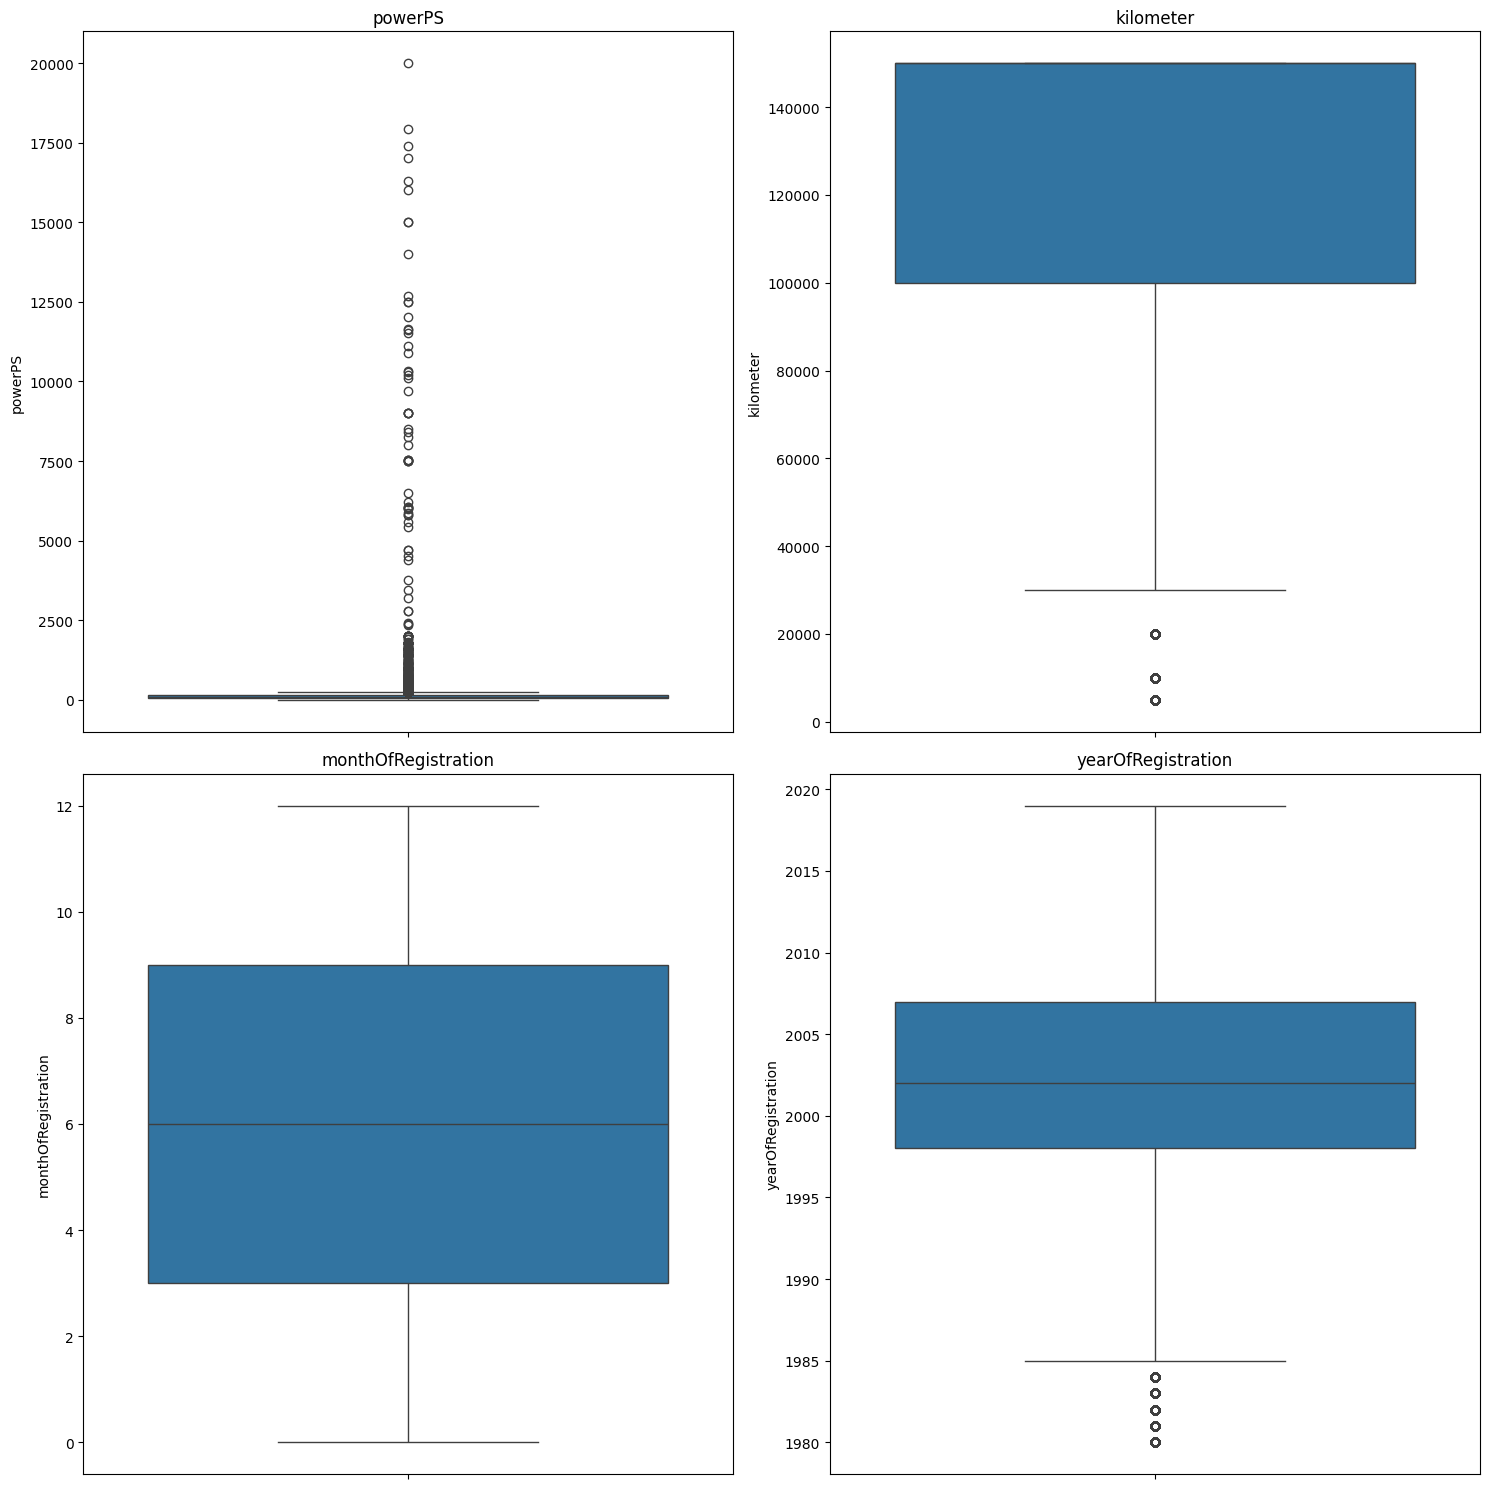

In [27]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
axes = ax.flatten()
for i,col in enumerate(numerical_cols):
  sns.boxplot(df[col],ax=axes[i])
  axes[i].set_title(col)
plt.tight_layout()
plt.show()

**Note:**

- `powerPS` contains a significant number of outliers that may affect model performance and should be handled appropriately.
- `kilometer` is right-skewed, with most entries concentrated at higher mileage levels.


In [28]:
%pip install colorama

Note: you may need to restart the kernel to use updated packages.


In [29]:
df.columns

Index(['name', 'price', 'abtest', 'vehicleType', 'yearOfRegistration',
       'gearbox', 'powerPS', 'model', 'kilometer', 'monthOfRegistration',
       'fuelType', 'brand', 'notRepairedDamage', 'dateCreated', 'postalCode'],
      dtype='object')

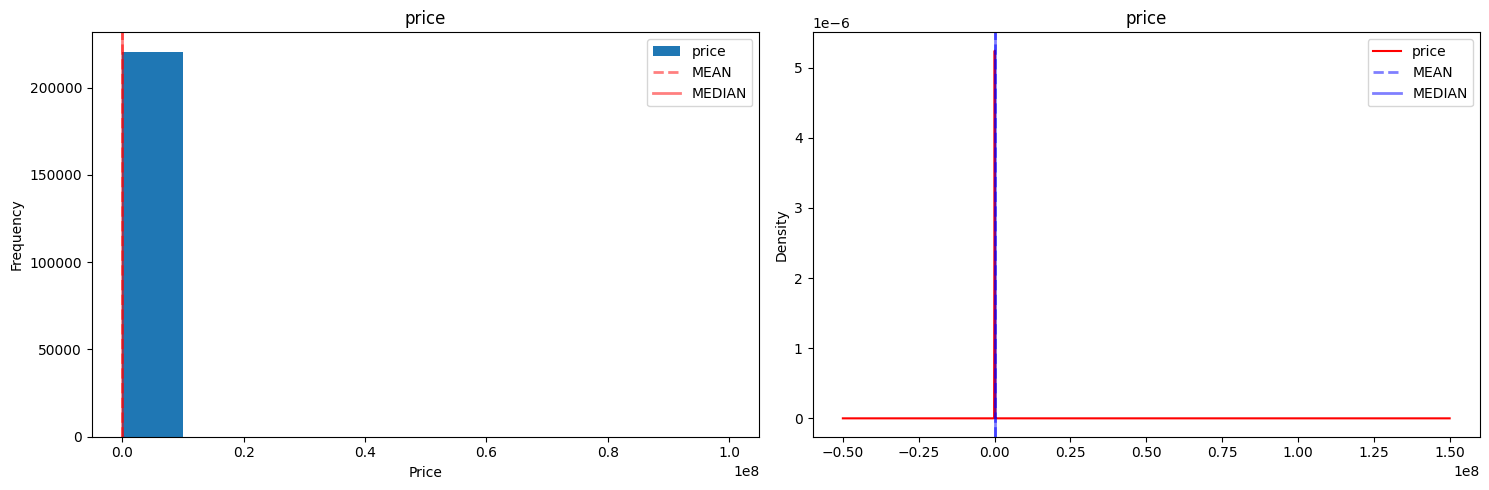

In [30]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes = axes.flatten()
col = 'price'
km_mean = df[col].mean()
km_median = df[col].median()
df[col].plot(kind='hist', bins=10, ax=axes[0], title='Histogram of Price in Range [200, 20K]', xlabel='Price')
axes[0].axvline(km_mean, color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0].axvline(km_median, color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0].legend()
df[col].plot(kind='kde', ax=axes[1], xlabel='KM',  color='red')
axes[1].axvline(km_mean, color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1].axvline(km_median, color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1].legend()

axes[0].set_title(col)
axes[1].set_title(col)


plt.tight_layout()
plt.show()

**Note:**

- The `price` range appears to be irregular or contains anomalies.
- To better understand the distribution, we will divide `price` into multiple ranges (bins) and analyze them separately.

In [31]:
from colorama import Fore, Back, Style

In [32]:
print(f"No. of cars with a price value higher than 20K: {Style.BRIGHT}{len(df[df['price'] > 20_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 30K: {Style.BRIGHT}{len(df[df['price'] > 30_000])}")
print(f"{Style.RESET_ALL}No. of cars with a price value higher than 40K: {Style.BRIGHT}{len(df[df['price'] > 40_000])}")
print(f"{Style.RESET_ALL}Mean of price: {Style.BRIGHT}{df['price'].mean():.2f}{Style.RESET_ALL}, Median of price: {Style.BRIGHT}{df['price'].median()}")
print(f"{Style.RESET_ALL}Min. price: {Style.BRIGHT}{df['price'].min()}{Style.RESET_ALL}, Max. price: {Style.BRIGHT}{df['price'].max()}")

No. of cars with a price value higher than 20K: 6928
No. of cars with a price value higher than 30K: 2712
No. of cars with a price value higher than 40K: 1506
Mean of price: 7742.11, Median of price: 2200.0
Min. price: 0, Max. price: 99999999


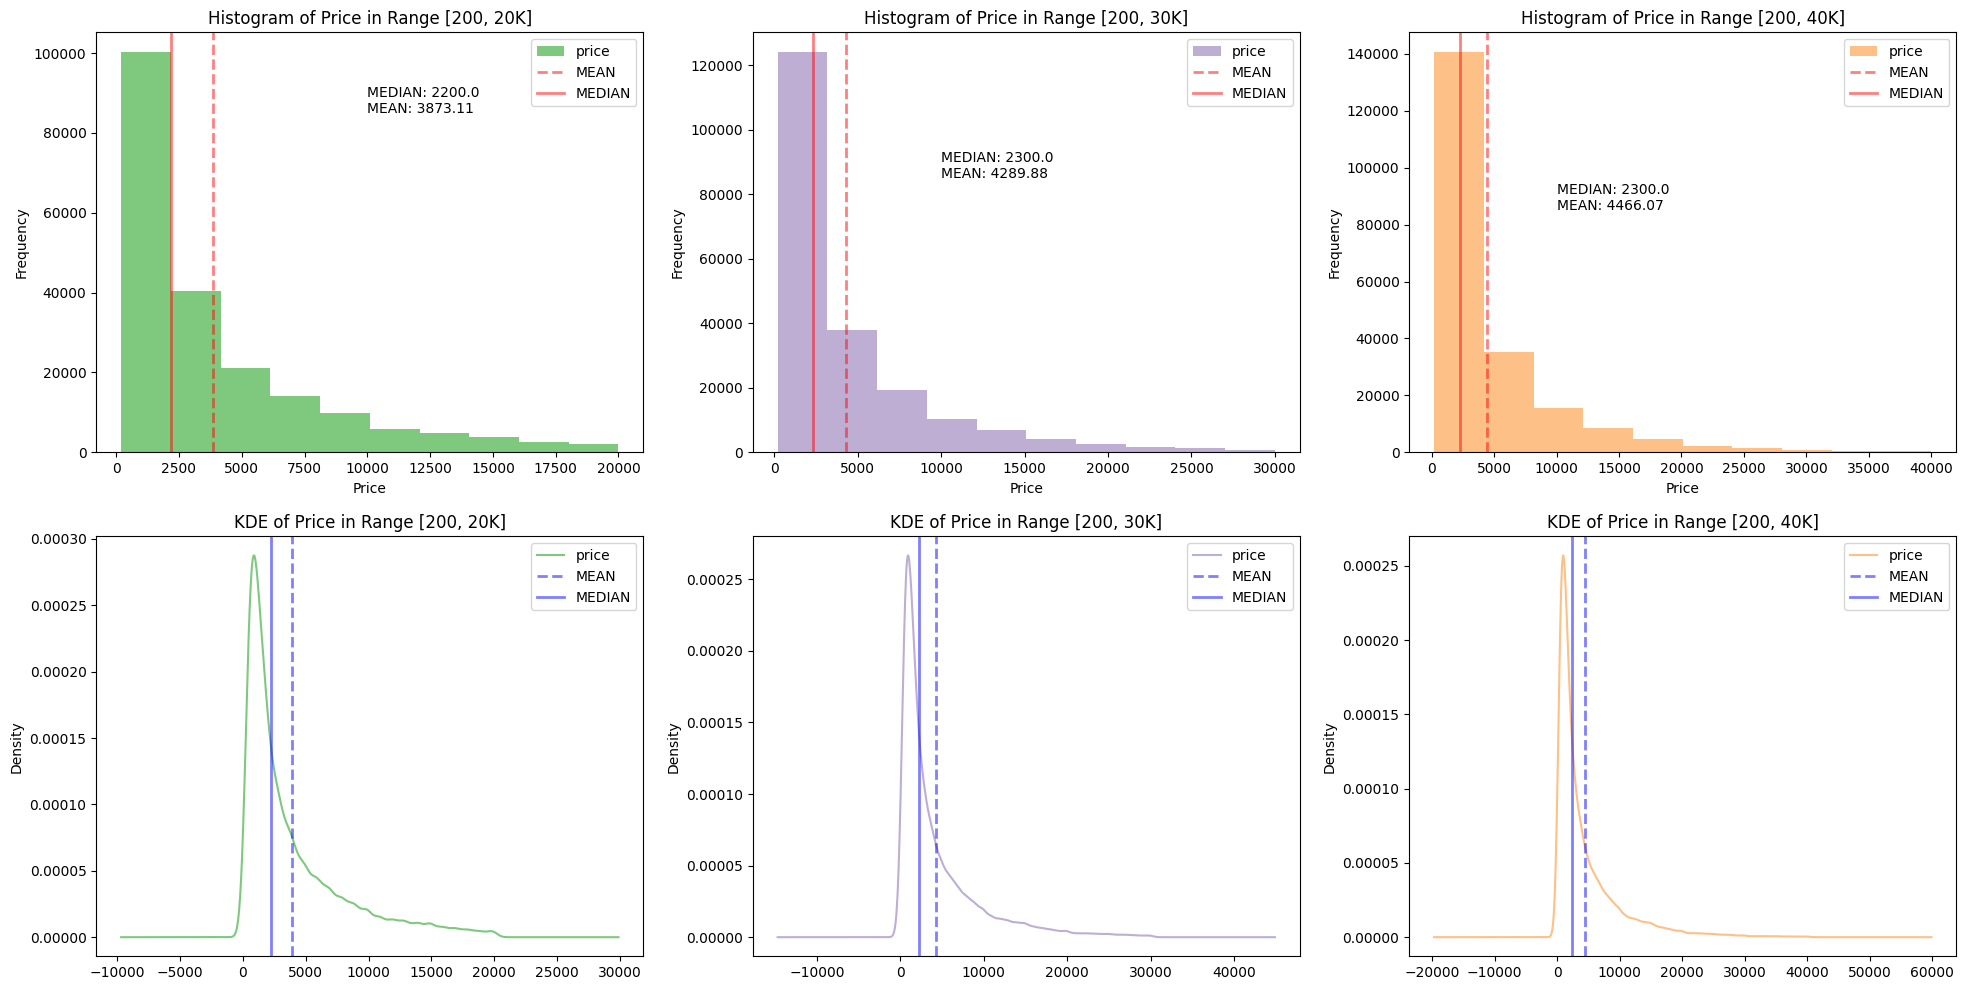

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(24, 12))

bins = 10

price_20 = df.loc[df['price'].between(200, 20_000), 'price']
price_30 = df.loc[df['price'].between(200, 30_000), 'price']
price_40 = df.loc[df['price'].between(200, 40_000), 'price']

price_20.plot(kind='hist', bins=bins, ax=axes[0,0], title='Histogram of Price in Range [200, 20K]', xlabel='Price', color=colors_5[0])
axes[0,0].axvline(price_20.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,0].axvline(price_20.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,0].legend()
txt = f'MEDIAN: {price_20.median()}\nMEAN: {price_20.mean():.2f}'
axes[0,0].text(10_000, 85_000, txt)

price_30.plot(kind='hist', bins=bins, ax=axes[0,1], title='Histogram of Price in Range [200, 30K]', xlabel='Price', color=colors_5[1])
axes[0,1].axvline(price_30.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,1].axvline(price_30.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,1].legend()
txt = f'MEDIAN: {price_30.median()}\nMEAN: {price_30.mean():.2f}'
axes[0,1].text(10_000, 85_000, txt)

price_40.plot(kind='hist', bins=bins, ax=axes[0,2], title='Histogram of Price in Range [200, 40K]', xlabel='Price', color=colors_5[2])
axes[0,2].axvline(price_40.mean(), color='red', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[0,2].axvline(price_40.median(), color='red', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[0,2].legend()
txt = f'MEDIAN: {price_40.median()}\nMEAN: {price_40.mean():.2f}'
axes[0,2].text(10_000, 85_000, txt)

price_20.plot(kind='kde', ax=axes[1,0], title='KDE of Price in Range [200, 20K]', xlabel='Price',  color=colors_5[0])
axes[1,0].axvline(price_20.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,0].axvline(price_20.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,0].legend()

price_30.plot(kind='kde', ax=axes[1,1], title='KDE of Price in Range [200, 30K]', xlabel='Price',  color=colors_5[1])
axes[1,1].axvline(price_30.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,1].axvline(price_30.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,1].legend()

price_40.plot(kind='kde', ax=axes[1,2], title='KDE of Price in Range [200, 40K]', xlabel='Price',  color=colors_5[2])
axes[1,2].axvline(price_40.mean(), color='blue', linestyle='dashed', linewidth=2, label='MEAN', alpha=.5)
axes[1,2].axvline(price_40.median(), color='blue', linestyle='solid', linewidth=2, label='MEDIAN', alpha=.5)
axes[1,2].legend()
plt.show()

**Note:**

- The price range of **[200, 20,000]** appears to be the most meaningful.
- It effectively captures the majority of valid data while eliminating a large proportion of outliers present in extremely low or high price ranges.

In [34]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [35]:
# drop null values, to remove notrepairedDammaged NA values
df.dropna(inplace=True)
df = df[df['notRepairedDamage'] != 'NaN']

# Drop cars with unacceptable prices
df = df[df['price'].between(200, 20000)]

# Drop cars with extreme powerPS
df = df[(df['powerPS'] > 0) & (df['powerPS'] <= 1000)]

# Add the 'age' column
current_year = 2025
df['age'] = current_year - df['yearOfRegistration']

# Drop unnecessary columns and rows
df.drop(['postalCode', 'dateCreated', 'name', 'monthOfRegistration', 'yearOfRegistration'], axis=1, inplace=True)


In [36]:
# Categorical to Numerical
categorical_features = ['vehicleType', 'fuelType', 'brand', 'model', 'abtest', 'notRepairedDamage', 'gearbox']
le = LabelEncoder()

for categorical_feature in categorical_features:
    df[categorical_feature] = le.fit_transform(df[categorical_feature])

In [37]:
df.columns

Index(['price', 'abtest', 'vehicleType', 'gearbox', 'powerPS', 'model',
       'kilometer', 'fuelType', 'brand', 'notRepairedDamage', 'age'],
      dtype='object')

In [38]:
numerical_cols = ['price','powerPS', 'kilometer', 'age']

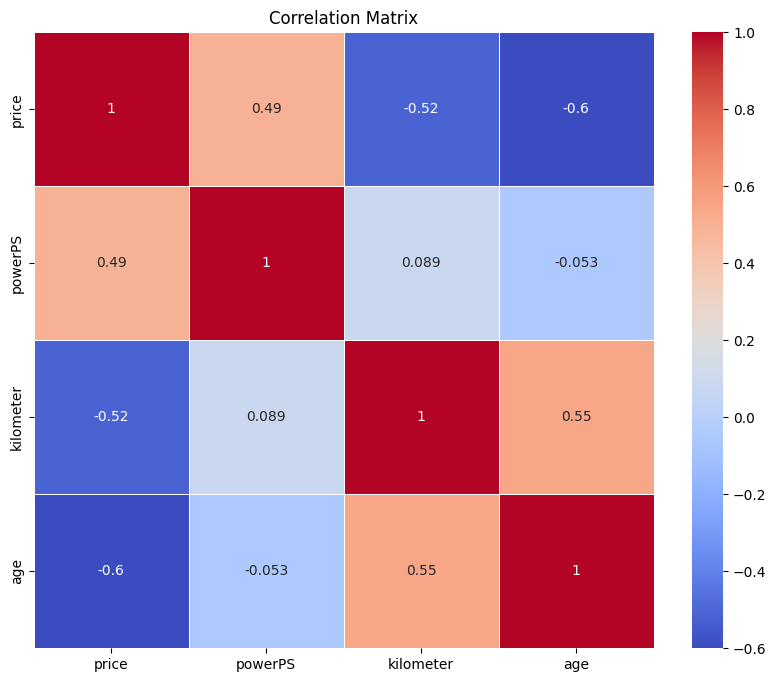

In [39]:
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

**Note:**

- There is a strong positive correlation between `powerPS` and `price`, indicating that vehicles with higher power tend to have higher prices.

In [40]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [41]:
features = df.drop(['price'], axis=1)
target = df['price']

scaler = StandardScaler()
numerical_features = ['kilometer', 'powerPS', 'age']
features[numerical_features] = scaler.fit_transform(features[numerical_features])

In [42]:
X_train, X_test,y_train, y_test = train_test_split(features, target, random_state=666, train_size=0.85)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=666, train_size=0.8235)

### ANN

In [43]:
epoch = 50
batch_size = 512
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_model.h5', monitor='val_mean_absolute_error', mode='min', verbose=1, save_best_only=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

In [44]:
model = Sequential()

# 1st Block
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu', name='Dense_1'))
model.add(BatchNormalization(name='BatchNorm_1'))
model.add(Dropout(0.3, name='Dropout_1'))

# 2nd Block
model.add(Dense(64, activation='relu', name='Dense_2'))
model.add(BatchNormalization(name='BatchNorm_2'))
model.add(Dropout(0.3, name='Dropout_2'))

# 3rd Block
model.add(Dense(128, activation='relu', name='Dense_3'))
model.add(BatchNormalization(name='BatchNorm_3'))
model.add(Dropout(0.4, name='Dropout_3'))

# 4th Block
model.add(Dense(64, activation='relu', name='Dense_4'))
model.add(BatchNormalization(name='BatchNorm_4'))
model.add(Dropout(0.3, name='Dropout_4'))

# 5th Block
model.add(Dense(32, activation='relu', name='Dense_5'))
model.add(BatchNormalization(name='BatchNorm_5'))

# Output Layer
model.add(Dense(1, activation='linear', name='Predictor'))

model.compile(loss='mean_squared_error',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_1 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_1                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_2                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_3                     │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_4                     │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BatchNorm_5                     │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Predictor (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,433 (87.63 KB)

 Trainable params: 21,793 (85.13 KB)

 Non-trainable params: 640 (2.50 KB)

In [46]:
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    batch_size=batch_size,
                    epochs=epoch,
                    callbacks=[mc, lr_schedule, es])

Epoch 1/50
197/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37453664.0000 - mean_absolute_error: 4360.3926
Epoch 1: val_mean_absolute_error improved from inf to 4368.94531, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 37444124.0000 - mean_absolute_error: 4359.9126 - val_loss: 37382188.0000 - val_mean_absolute_error: 4368.9453 - learning_rate: 0.0010
Epoch 2/50
195/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37174820.0000 - mean_absolute_error: 4345.2119
Epoch 2: val_mean_absolute_error improved from 4368.94531 to 4368.30664, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 37166152.0000 - mean_absolute_error: 4345.0928 - val_loss: 37283152.0000 - val_mean_absolute_error: 4368.3066 - learning_rate: 0.0010
Epoch 3/50
190/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36873480.0000 - mean_absolute_error: 4336.9263
Epoch 3: val_mean_absolute_error improved from 4368.30664 to 4349.06787, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36857372.0000 - mean_absolute_error: 4335.9580 - val_loss: 36985948.0000 - val_mean_absolute_error: 4349.0679 - learning_rate: 0.0010
Epoch 4/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36148728.0000 - mean_absolute_error: 4304.4771
Epoch 4: val_mean_absolute_error improved from 4349.06787 to 4297.39893, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36160932.0000 - mean_absolute_error: 4304.9141 - val_loss: 36331028.0000 - val_mean_absolute_error: 4297.3989 - learning_rate: 0.0010
Epoch 5/50
189/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36137028.0000 - mean_absolute_error: 4298.4243
Epoch 5: val_mean_absolute_error improved from 4297.39893 to 4267.65869, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 36113720.0000 - mean_absolute_error: 4297.2236 - val_loss: 35788068.0000 - val_mean_absolute_error: 4267.6587 - learning_rate: 0.0010
Epoch 6/50
198/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35290360.0000 - mean_absolute_error: 4250.6235
Epoch 6: val_mean_absolute_error did not improve from 4267.65869
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35294024.0000 - mean_absolute_error: 4250.9604 - val_loss: 35395864.0000 - val_mean_absolute_error: 4269.1011 - learning_rate: 0.0010
Epoch 7/50
206/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34434364.0000 - mean_absolute_error: 4208.2441
Epoch 7: val_mean_absolute_error improved from 4267.65869 to 4244.47168, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34438048.0000 - mean_absolute_error: 4208.4268 - val_loss: 34984064.0000 - val_mean_absolute_error: 4244.4717 - learning_rate: 0.0010
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34332760.0000 - mean_absolute_error: 4200.7520
Epoch 8: val_mean_absolute_error improved from 4244.47168 to 4189.94629, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 34331152.0000 - mean_absolute_error: 4200.6572 - val_loss: 33989268.0000 - val_mean_absolute_error: 4189.9463 - learning_rate: 0.0010
Epoch 9/50
194/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33395106.0000 - mean_absolute_error: 4147.6108
Epoch 9: val_mean_absolute_error improved from 4189.94629 to 4162.24609, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 33386124.0000 - mean_absolute_error: 4146.9878 - val_loss: 33343622.0000 - val_mean_absolute_error: 4162.2461 - learning_rate: 0.0010
Epoch 10/50
199/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32646934.0000 - mean_absolute_error: 4102.0640
Epoch 10: val_mean_absolute_error improved from 4162.24609 to 4130.57422, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 32637234.0000 - mean_absolute_error: 4101.4492 - val_loss: 32999604.0000 - val_mean_absolute_error: 4130.5742 - learning_rate: 0.0010
Epoch 11/50
196/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32053702.0000 - mean_absolute_error: 4067.3630
Epoch 11: val_mean_absolute_error improved from 4130.57422 to 4052.63379, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 32023130.0000 - mean_absolute_error: 4065.3433 - val_loss: 31676636.0000 - val_mean_absolute_error: 4052.6338 - learning_rate: 0.0010
Epoch 12/50
195/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30688308.0000 - mean_absolute_error: 3978.9944
Epoch 12: val_mean_absolute_error improved from 4052.63379 to 4005.42944, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 30686788.0000 - mean_absolute_error: 3978.9924 - val_loss: 30998804.0000 - val_mean_absolute_error: 4005.4294 - learning_rate: 0.0010
Epoch 13/50
203/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29990802.0000 - mean_absolute_error: 3938.0100
Epoch 13: val_mean_absolute_error improved from 4005.42944 to 3962.01465, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 29983290.0000 - mean_absolute_error: 3937.4705 - val_loss: 30198372.0000 - val_mean_absolute_error: 3962.0146 - learning_rate: 0.0010
Epoch 14/50
196/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28730374.0000 - mean_absolute_error: 3855.0698
Epoch 14: val_mean_absolute_error improved from 3962.01465 to 3910.06934, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28735322.0000 - mean_absolute_error: 3855.3308 - val_loss: 29591820.0000 - val_mean_absolute_error: 3910.0693 - learning_rate: 0.0010
Epoch 15/50
196/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28154978.0000 - mean_absolute_error: 3814.1648
Epoch 15: val_mean_absolute_error improved from 3910.06934 to 3810.87793, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 28132086.0000 - mean_absolute_error: 3812.7334 - val_loss: 28212868.0000 - val_mean_absolute_error: 3810.8779 - learning_rate: 0.0010
Epoch 16/50
193/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27291474.0000 - mean_absolute_error: 3752.1384
Epoch 16: val_mean_absolute_error improved from 3810.87793 to 3712.26001, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 27251556.0000 - mean_absolute_error: 3749.7786 - val_loss: 26679434.0000 - val_mean_absolute_error: 3712.2600 - learning_rate: 0.0010
Epoch 17/50
206/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26049074.0000 - mean_absolute_error: 3673.2268
Epoch 17: val_mean_absolute_error did not improve from 3712.26001
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 26044842.0000 - mean_absolute_error: 3672.8894 - val_loss: 27081224.0000 - val_mean_absolute_error: 3733.6042 - learning_rate: 0.0010
Epoch 18/50
188/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25312854.0000 - mean_absolute_error: 3615.9131
Epoch 18: val_mean_absolute_error improved from 3712.26001 to 3657.11719, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 25260608.0000 - mean_absolute_error: 3612.4146 - val_loss: 25949478.0000 - val_mean_absolute_error: 3657.1172 - learning_rate: 0.0010
Epoch 19/50
201/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23847036.0000 - mean_absolute_error: 3511.8145
Epoch 19: val_mean_absolute_error improved from 3657.11719 to 3589.28662, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23841794.0000 - mean_absolute_error: 3511.3833 - val_loss: 24713296.0000 - val_mean_absolute_error: 3589.2866 - learning_rate: 0.0010
Epoch 20/50
198/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22855452.0000 - mean_absolute_error: 3440.9270
Epoch 20: val_mean_absolute_error improved from 3589.28662 to 3487.33447, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 22844692.0000 - mean_absolute_error: 3439.9070 - val_loss: 23824258.0000 - val_mean_absolute_error: 3487.3345 - learning_rate: 0.0010
Epoch 21/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21711518.0000 - mean_absolute_error: 3354.5767
Epoch 21: val_mean_absolute_error improved from 3487.33447 to 3442.44067, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 21707716.0000 - mean_absolute_error: 3354.0598 - val_loss: 23043516.0000 - val_mean_absolute_error: 3442.4407 - learning_rate: 0.0010
Epoch 22/50
192/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20769164.0000 - mean_absolute_error: 3272.8313
Epoch 22: val_mean_absolute_error improved from 3442.44067 to 3346.65332, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 20748962.0000 - mean_absolute_error: 3271.2288 - val_loss: 21523112.0000 - val_mean_absolute_error: 3346.6533 - learning_rate: 0.0010
Epoch 23/50
201/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19816586.0000 - mean_absolute_error: 3199.5503
Epoch 23: val_mean_absolute_error improved from 3346.65332 to 3255.80981, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19806034.0000 - mean_absolute_error: 3198.5278 - val_loss: 20484636.0000 - val_mean_absolute_error: 3255.8098 - learning_rate: 0.0010
Epoch 24/50
192/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18929288.0000 - mean_absolute_error: 3121.0078
Epoch 24: val_mean_absolute_error improved from 3255.80981 to 3200.83496, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 18895934.0000 - mean_absolute_error: 3118.1726 - val_loss: 19908530.0000 - val_mean_absolute_error: 3200.8350 - learning_rate: 0.0010
Epoch 25/50
191/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17756206.0000 - mean_absolute_error: 3024.4548
Epoch 25: val_mean_absolute_error improved from 3200.83496 to 3190.10059, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 17735596.0000 - mean_absolute_error: 3022.2310 - val_loss: 19443156.0000 - val_mean_absolute_error: 3190.1006 - learning_rate: 0.0010
Epoch 26/50
188/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17014374.0000 - mean_absolute_error: 2951.9788
Epoch 26: val_mean_absolute_error improved from 3190.10059 to 3084.04199, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16968312.0000 - mean_absolute_error: 2947.7903 - val_loss: 18989404.0000 - val_mean_absolute_error: 3084.0420 - learning_rate: 0.0010
Epoch 27/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15804748.0000 - mean_absolute_error: 2843.3030
Epoch 27: val_mean_absolute_error improved from 3084.04199 to 2986.82178, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15803531.0000 - mean_absolute_error: 2843.1782 - val_loss: 17204938.0000 - val_mean_absolute_error: 2986.8218 - learning_rate: 0.0010
Epoch 28/50
197/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14769714.0000 - mean_absolute_error: 2739.6057
Epoch 28: val_mean_absolute_error improved from 2986.82178 to 2790.04883, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14760666.0000 - mean_absolute_error: 2738.8271 - val_loss: 15532426.0000 - val_mean_absolute_error: 2790.0488 - learning_rate: 0.0010
Epoch 29/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13813446.0000 - mean_absolute_error: 2646.9722
Epoch 29: val_mean_absolute_error improved from 2790.04883 to 2663.01099, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13812420.0000 - mean_absolute_error: 2646.8591 - val_loss: 14259580.0000 - val_mean_absolute_error: 2663.0110 - learning_rate: 0.0010
Epoch 30/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12893682.0000 - mean_absolute_error: 2552.6360
Epoch 30: val_mean_absolute_error improved from 2663.01099 to 2619.38306, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12891238.0000 - mean_absolute_error: 2552.3579 - val_loss: 14009777.0000 - val_mean_absolute_error: 2619.3831 - learning_rate: 0.0010
Epoch 31/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12148992.0000 - mean_absolute_error: 2469.5183
Epoch 31: val_mean_absolute_error did not improve from 2619.38306
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 12143135.0000 - mean_absolute_error: 2468.9670 - val_loss: 13794660.0000 - val_mean_absolute_error: 2621.5020 - learning_rate: 0.0010
Epoch 32/50
197/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11134828.0000 - mean_absolute_error: 2361.9792
Epoch 32: val_mean_absolute_error improved from 2619.38306 to 2558.42529, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11135941.0000 - mean_absolute_error: 2361.8474 - val_loss: 13183160.0000 - val_mean_absolute_error: 2558.4253 - learning_rate: 0.0010
Epoch 33/50
202/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10623393.0000 - mean_absolute_error: 2305.5112
Epoch 33: val_mean_absolute_error improved from 2558.42529 to 2392.13916, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10614471.0000 - mean_absolute_error: 2304.2854 - val_loss: 11433440.0000 - val_mean_absolute_error: 2392.1392 - learning_rate: 0.0010
Epoch 34/50
196/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9755833.0000 - mean_absolute_error: 2196.8845
Epoch 34: val_mean_absolute_error improved from 2392.13916 to 2314.92261, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9750271.0000 - mean_absolute_error: 2196.0085 - val_loss: 11410007.0000 - val_mean_absolute_error: 2314.9226 - learning_rate: 0.0010
Epoch 35/50
194/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9101381.0000 - mean_absolute_error: 2114.7258
Epoch 35: val_mean_absolute_error improved from 2314.92261 to 2210.85425, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9089641.0000 - mean_absolute_error: 2113.1799 - val_loss: 10466612.0000 - val_mean_absolute_error: 2210.8542 - learning_rate: 0.0010
Epoch 36/50
192/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8502078.0000 - mean_absolute_error: 2031.9790
Epoch 36: val_mean_absolute_error improved from 2210.85425 to 2154.82886, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8484211.0000 - mean_absolute_error: 2029.7053 - val_loss: 9543986.0000 - val_mean_absolute_error: 2154.8289 - learning_rate: 0.0010
Epoch 37/50
193/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7813686.0000 - mean_absolute_error: 1938.8030
Epoch 37: val_mean_absolute_error improved from 2154.82886 to 2093.08081, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7802822.0000 - mean_absolute_error: 1937.5304 - val_loss: 9001791.0000 - val_mean_absolute_error: 2093.0808 - learning_rate: 0.0010
Epoch 38/50
188/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7065321.0000 - mean_absolute_error: 1827.7360
Epoch 38: val_mean_absolute_error improved from 2093.08081 to 1911.47192, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7071400.5000 - mean_absolute_error: 1829.3484 - val_loss: 8063442.5000 - val_mean_absolute_error: 1911.4719 - learning_rate: 0.0010
Epoch 39/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6591068.5000 - mean_absolute_error: 1761.5260
Epoch 39: val_mean_absolute_error improved from 1911.47192 to 1839.08337, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6590937.5000 - mean_absolute_error: 1761.5430 - val_loss: 7163545.0000 - val_mean_absolute_error: 1839.0834 - learning_rate: 0.0010
Epoch 40/50
195/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6067866.0000 - mean_absolute_error: 1684.2421
Epoch 40: val_mean_absolute_error did not improve from 1839.08337
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6068855.0000 - mean_absolute_error: 1684.3826 - val_loss: 7510566.0000 - val_mean_absolute_error: 1916.5530 - learning_rate: 0.0010
Epoch 41/50
191/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5871216.0000 - mean_absolute_error: 1656.1198
Epoch 41: val_mean_absolute_error improved from 1839.08337 to 1743.13123, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5854421.5000 - mean_absolute_error: 1653.0748 - val_loss: 6825467.0000 - val_mean_absolute_error: 1743.1312 - learning_rate: 0.0010
Epoch 42/50
203/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5362125.5000 - mean_absolute_error: 1572.3131
Epoch 42: val_mean_absolute_error did not improve from 1743.13123
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5359185.0000 - mean_absolute_error: 1571.7838 - val_loss: 7585297.0000 - val_mean_absolute_error: 1874.0627 - learning_rate: 0.0010
Epoch 43/50
194/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4948119.0000 - mean_absolute_error: 1499.2266
Epoch 43: val_mean_absolute_error improved from 1743.13123 to 1611.09448, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4947320.5000 - mean_absolute_error: 1499.0122 - val_loss: 5907080.5000 - val_mean_absolute_error: 1611.0945 - learning_rate: 0.0010
Epoch 44/50
194/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4730213.0000 - mean_absolute_error: 1453.5792
Epoch 44: val_mean_absolute_error improved from 1611.09448 to 1397.42529, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4723001.5000 - mean_absolute_error: 1452.6884 - val_loss: 4756787.0000 - val_mean_absolute_error: 1397.4253 - learning_rate: 0.0010
Epoch 45/50
198/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4450246.5000 - mean_absolute_error: 1414.6357
Epoch 45: val_mean_absolute_error improved from 1397.42529 to 1360.77783, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4445936.5000 - mean_absolute_error: 1413.4459 - val_loss: 4253544.5000 - val_mean_absolute_error: 1360.7778 - learning_rate: 0.0010
Epoch 46/50
197/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4204929.0000 - mean_absolute_error: 1366.0310
Epoch 46: val_mean_absolute_error did not improve from 1360.77783
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4202217.5000 - mean_absolute_error: 1365.3560 - val_loss: 4952666.5000 - val_mean_absolute_error: 1447.7717 - learning_rate: 0.0010
Epoch 47/50
205/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4027292.2500 - mean_absolute_error: 1327.6008
Epoch 47: val_mean_absolute_error improved from 1360.77783 to 1347.61426, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4026765.2500 - mean_absolute_error: 1327.4382 - val_loss: 4554946.5000 - val_mean_absolute_error: 1347.6143 - learning_rate: 0.0010
Epoch 48/50
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3892925.5000 - mean_absolute_error: 1302.4878
Epoch 48: val_mean_absolute_error did not improve from 1347.61426
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3892115.7500 - mean_absolute_error: 1302.3374 - val_loss: 4788769.0000 - val_mean_absolute_error: 1389.5634 - learning_rate: 0.0010
Epoch 49/50
193/208 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3779428.0000 - mean_absolute_error: 1275.0397
Epoch 49: val_mean_absolute_error improved from 1347.61426 to 1265.43323, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3772883.5000 - mean_absolute_error: 1273.9935 - val_loss: 4207388.5000 - val_mean_absolute_error: 1265.4332 - learning_rate: 0.0010
Epoch 50/50
190/208 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3634840.5000 - mean_absolute_error: 1245.0573
Epoch 50: val_mean_absolute_error improved from 1265.43323 to 1195.10547, saving model to ./best_model.h5


208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3631387.0000 - mean_absolute_error: 1244.4021 - val_loss: 3685276.5000 - val_mean_absolute_error: 1195.1055 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.


In [47]:
dnn_eval = model.evaluate(X_test, y_test)
dnn_preds = model.predict(X_test)

print(f"{Fore.BLUE}DNN - Test set\n\nMSE: {Fore.RED}{dnn_eval[0]}\n{Fore.BLUE}MAE: {Fore.RED}{dnn_eval[1]:.2f}")
print(f"{Fore.BLUE}R2-Score: {Fore.RED}{r2_score(y_test, dnn_preds):.3f}")

713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 3691945.7500 - mean_absolute_error: 1188.6248
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step
DNN - Test set

MSE: 3663366.25
MAE: 1187.95
R2-Score: 0.800


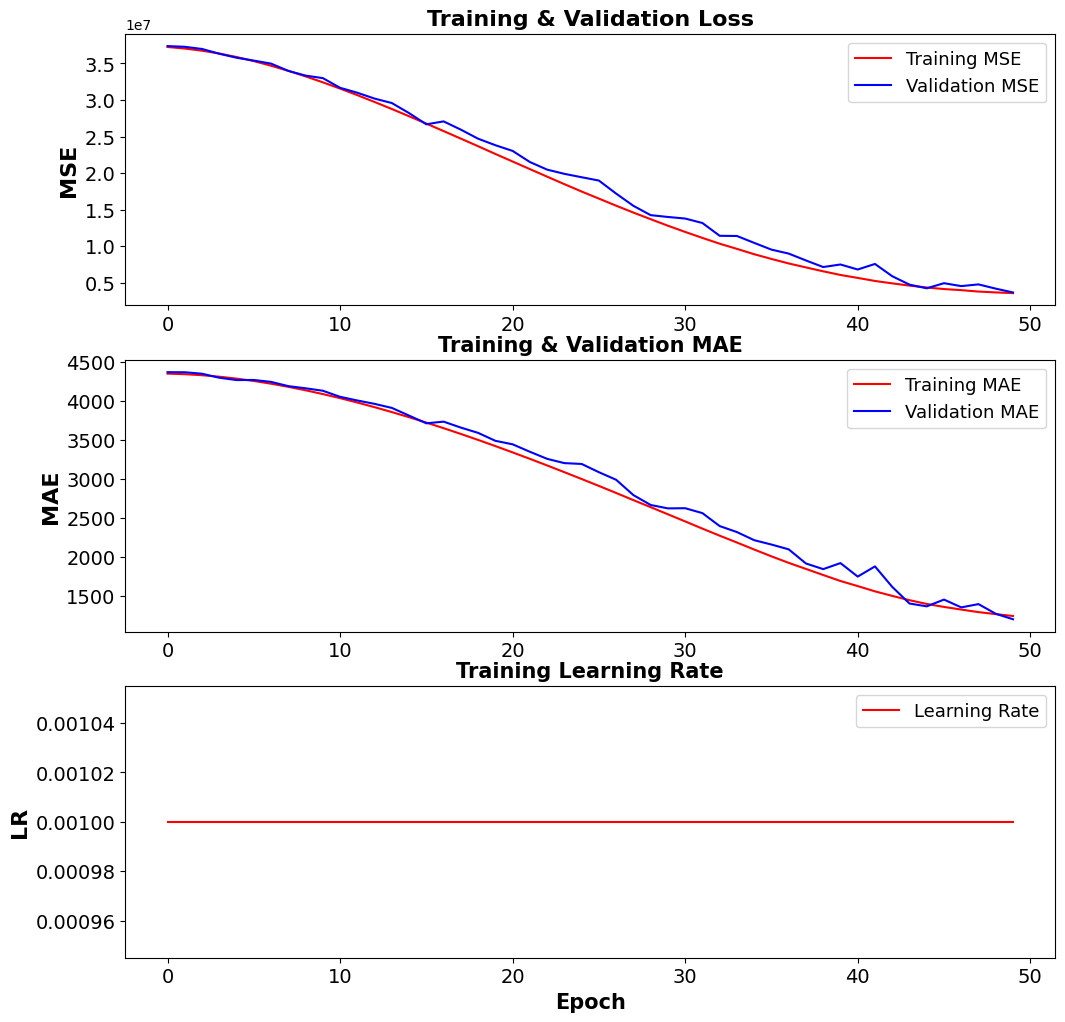

In [48]:
lr = history.history['learning_rate']
loss = history.history['loss']
val_loss = history.history['val_loss']
t_mae = history.history['mean_absolute_error']
v_mae = history.history['val_mean_absolute_error']

plt.figure(figsize=(12, 12))

# MSE
plt.subplot(3, 1, 1)
plt.plot(loss, label='Training MSE', color='r')
plt.plot(val_loss, label='Validation MSE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('MSE', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=16, weight='bold')

# MAE
plt.subplot(3, 1, 2)
plt.plot(t_mae, label='Training MAE', color='r')
plt.plot(v_mae, label='Validation MAE', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=13)
plt.ylabel('MAE', fontsize=16, weight='bold')
plt.title('Training & Validation MAE', fontsize=15, weight='bold')

# Learning Rate
plt.subplot(3, 1, 3)
plt.plot(lr, label='Learning Rate', color='r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('LR', fontsize=16, weight='bold')
plt.title('Training Learning Rate', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

In [49]:
import random

In [50]:
preds = dnn_preds.reshape(-1)

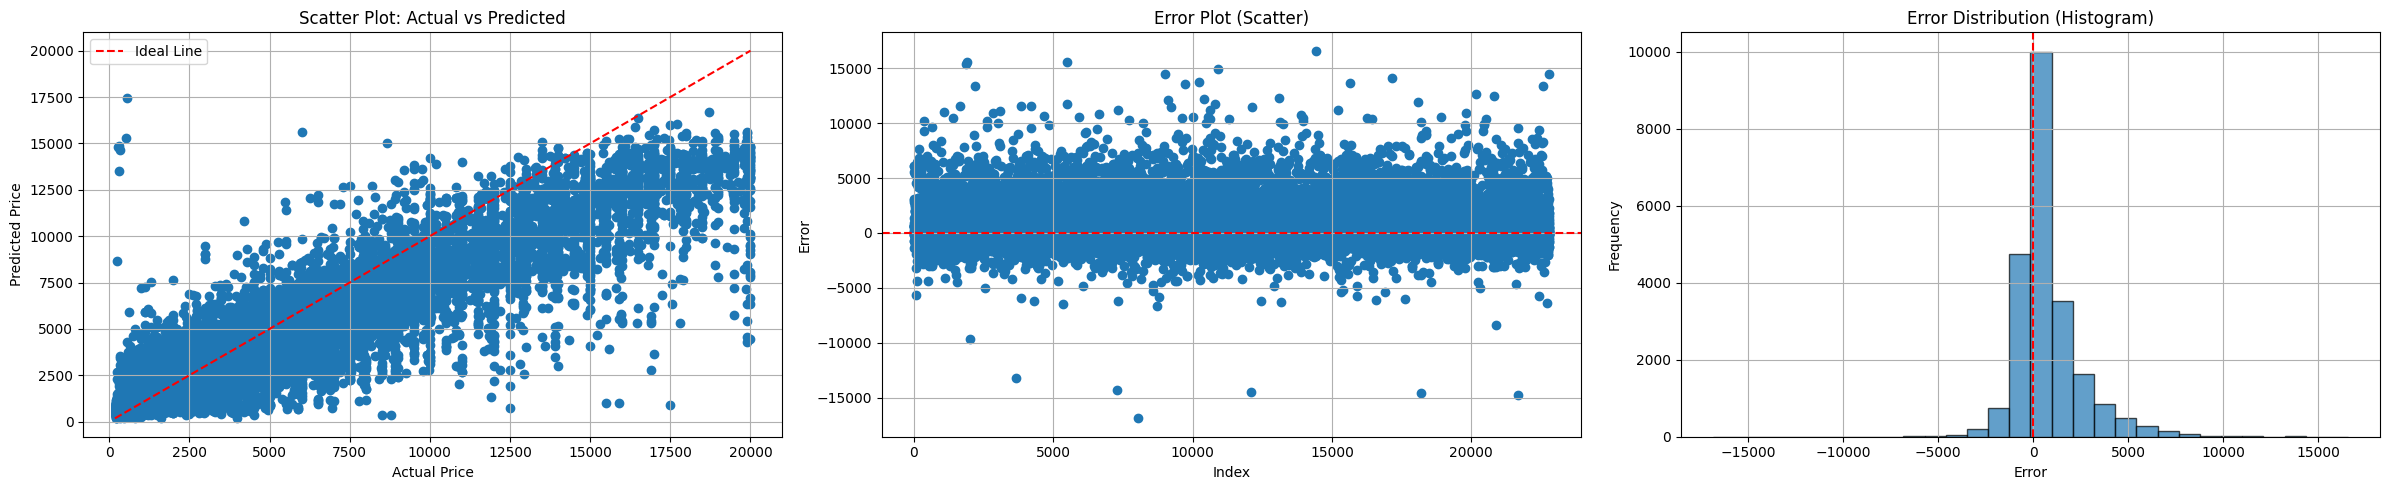

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(24, 5))  

# 1. Scatter plot: Actual vs Predicted
axes[0].scatter(y_test, preds)
# Add reference line (ideal predictions line)
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Line')
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Scatter Plot: Actual vs Predicted')
axes[0].legend()
axes[0].grid(True)

# 2. Error plot: Scatter instead of line
error = y_test - preds
axes[1].scatter(range(len(error)), error)
axes[1].axhline(0, color='red', linestyle='--') 
axes[1].set_title('Error Plot (Scatter)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Error')
axes[1].grid(True)

# 3. Error distribution plot
axes[2].hist(error, bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(0, color='red', linestyle='--') 
axes[2].set_title('Error Distribution (Histogram)')
axes[2].set_xlabel('Error')
axes[2].set_ylabel('Frequency')
axes[2].grid(True)

# Layout
plt.tight_layout()
plt.show()


In [52]:
step = np.random.randint(1, 101)
for _ in range(10):
    print(y_test.values[step] - dnn_preds[step])
    step = np.random.randint(1, 101)

[1505.74462891]
[428.99121094]
[228.72821045]
[-1082.83166504]
[-401.77050781]
[6078.56787109]
[-522.46032715]
[123.36694336]
[2.53344727]
[633.48266602]


**Note:**

- The model's R2 score is **0.824**, which is good but lower than expected. We will explore other traditional models to improve performance.
- The difference between actual and predicted prices is relatively large, indicating room for improvement.
- In most cases, the predicted price is lower than the actual price.
- The error distribution appears to be normal, suggesting the model has fit the data reasonably well.